##### Requirements

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten
from keras import regularizers
import keras.backend as K
from keras.models import load_model
from tensorflow.core.util import event_pb2
from tensorflow.python.lib.io import tf_record
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import cv2

#custom
import saliency.core as saliency
import pickle
import itertools

# Dataset loader

In [2]:
train_dir = 'hmt_dataset/HMT_train' #you should change to your directory
test_dir = 'hmt_dataset/HMT_test' #you should change to your directory

train_datagen = ImageDataGenerator(rescale=1/255.,
shear_range=0.1,
rotation_range=15,
horizontal_flip=True,
vertical_flip=True)

test_datagen = ImageDataGenerator(rescale=1/255.)

train_generator = train_datagen.flow_from_directory(train_dir,
class_mode='categorical',
interpolation='bilinear',
target_size=(224, 224),
batch_size=32,
shuffle=True)

# changed batch size to 62 from 32
test_generator = test_datagen.flow_from_directory(test_dir,
class_mode='categorical',
interpolation='bilinear',
target_size=(224, 224),
batch_size=62,
shuffle=False)

val_generator = test_datagen.flow_from_directory(test_dir,
class_mode='categorical',
interpolation='bilinear',
target_size=(224, 224),
batch_size=32,
shuffle=False)

Found 4504 images belonging to 8 classes.
Found 496 images belonging to 8 classes.
Found 496 images belonging to 8 classes.


Overrided

# Create Model

In [3]:
weight_decay = 5e-4
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(224, 224, 3), kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# flatten?

#model.add(Flatten())
model.add(GlobalAveragePooling2D())
#model.add(Dense(1024, activation='relu', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.5),
#                bias_initializer=keras.initializers.Zeros(), kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(8, activation='softmax', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.5),
                bias_initializer=keras.initializers.Zeros(), kernel_regularizer=regularizers.l2(weight_decay)))

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                    

# Training

In [5]:
# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='sgd',
              metrics=['accuracy'])

In [6]:
def lr_scheduler(epoch):
    base_ep = 15
    return 1e-3 * (.5 ** (epoch // base_ep))
lr_reduce_cb = keras.callbacks.LearningRateScheduler(lr_scheduler)
tensorboard_cb = keras.callbacks.TensorBoard(log_dir='log', write_graph=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=8, min_delta=0.)

In [7]:
from tensorflow.python.client import device_lib
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

In [8]:
fit_out = model.fit_generator(generator=train_generator,
                    steps_per_epoch=train_generator.n // 32,
                    epochs=150,
                    callbacks=[tensorboard_cb],                  
                    shuffle = True,
                    verbose=1)

history = fit_out.history
#pickle history
with open('log/train/hmt_history.pkl', 'wb') as f:
    pickle.dump(history, f)

C:\Users\nich_\AppData\Local\Temp\ipykernel_19036\1590167677.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  fit_out = model.fit_generator(generator=train_generator,


Epoch 1/150
140/140 [==============================] - 71s 476ms/step - loss: 1.9702 - accuracy: 0.2393
Epoch 2/150
140/140 [==============================] - 38s 271ms/step - loss: 1.5994 - accuracy: 0.3696
Epoch 3/150
140/140 [==============================] - 38s 271ms/step - loss: 1.3723 - accuracy: 0.4640
Epoch 4/150
140/140 [==============================] - 38s 271ms/step - loss: 1.2326 - accuracy: 0.5056
Epoch 5/150
140/140 [==============================] - 39s 275ms/step - loss: 1.1587 - accuracy: 0.5420
Epoch 6/150
140/140 [==============================] - 40s 288ms/step - loss: 1.1090 - accuracy: 0.5754
Epoch 7/150
140/140 [==============================] - 60s 430ms/step - loss: 1.0722 - accuracy: 0.5915
Epoch 8/150
140/140 [==============================] - 40s 287ms/step - loss: 1.0719 - accuracy: 0.5977
Epoch 9/150
140/140 [==============================] - 38s 272ms/step - loss: 1.0362 - accuracy: 0.6102
Epoch 10/150
140/140 [==============================] - 38s 270m

In [9]:
model.save('HMT.h5')

# Load Model

In [5]:
with open('log/train/hmt_history.pkl', 'rb') as f: #TODO rename
    history = pickle.load(f)

model=load_model('models/HMT.h5')

**Training Accuracy/Loss**

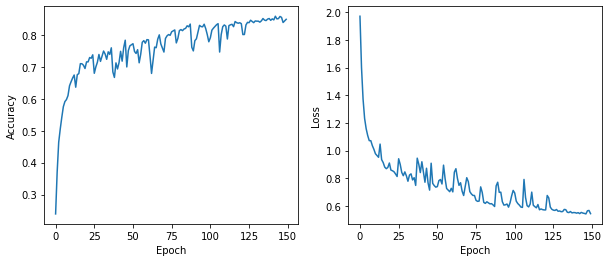

In [6]:
# Task 2.3.a - included since I ended up retraining the model
# Plot the generated figures from the fit history
plt.figure(figsize=(10,4))

# Accuracy vs. Epoch
plt.subplot(121)
plt.plot(history['accuracy'], label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Loss vs. Epoch
plt.subplot(122)
plt.plot(history['loss'], label = 'loss')
plt.xlabel('Epoch')
plt.ylabel('Loss');
plt.savefig('hmt_acc_loss.png')
plt.show()

**Generate Testing Data**

In [7]:
# Generate some test data
test_generator.reset()
image_batch,label_batch=test_generator.next()

class_names = ['Tumor', 'Stroma', 'Complex', 'Lympho', 'Debris', 'Mucosa', 'Adiopse', 'Empty']
num_classes = len(class_names)

# For Overall Classification Accuracy
eval_generator = test_datagen.flow_from_directory(test_dir, class_mode='categorical', interpolation='bilinear',
                                                  target_size=(224, 224), batch_size=496, shuffle=True)

# For Classwise Classification Accuracy
class_generator = test_datagen.flow_from_directory(test_dir, class_mode='categorical', interpolation='bilinear', 
                                                   target_size=(224, 224), batch_size=62, shuffle=False)


Found 496 images belonging to 8 classes.
Found 496 images belonging to 8 classes.


**Overall Classification Accuracy**

In [8]:
# Task 2.3.b
# Evaluate the model's performance on the entire test dataset and output the reported accuracy

eval_generator.reset()
image_batch,label_batch=eval_generator.next()
accuracy, _ = model.evaluate(image_batch,label_batch)
print(f'Overall model accuracy: {accuracy:.4f}')

16/16 [==============================] - 5s 45ms/step - loss: 0.5554 - accuracy: 0.8347
Overall model accuracy: 0.5554


**Classwise Classification Accuracy**

In [9]:
accuracy = []
for idx in range(num_classes):
    image_batch,label_batch=class_generator.next()
    accuracy.append(model.evaluate(image_batch,label_batch)[1])
print()
for idx in range(num_classes):    
    print(f'{class_names[idx]} model accuracy: {accuracy[idx]:.4f}')

2/2 [==============================] - 0s 29ms/step - loss: 0.2352 - accuracy: 1.0000

Tumor model accuracy: 0.8548
Stroma model accuracy: 0.7581
Complex model accuracy: 0.7742
Lympho model accuracy: 0.8548
Debris model accuracy: 0.6613
Mucosa model accuracy: 0.8226
Adiopse model accuracy: 0.9516
Empty model accuracy: 1.0000


**Classwise ROC/AUC**

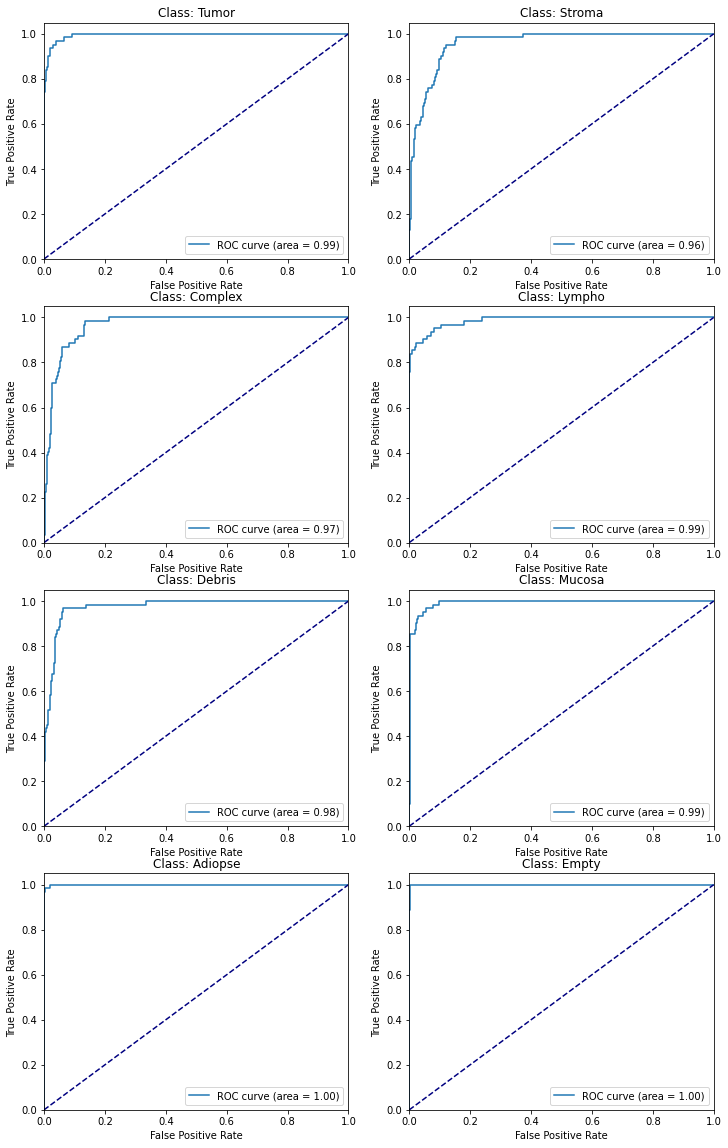

In [10]:
eval_generator.reset()
image_batch, y_test=eval_generator.next()

y_score = model.predict(image_batch)
y_pred = np.argmax(y_score, axis=1)

fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(12,20))

for idx in range(8):
    
    plt.subplot(4,2,idx + 1)
    
    fpr[idx], tpr[idx], _ = metrics.roc_curve(y_test[:, idx], y_score[:, idx])
    roc_auc[idx] = metrics.auc(fpr[idx], tpr[idx])
    
    plt.plot(fpr[idx], tpr[idx], label="ROC curve (area = %0.2f)" % roc_auc[idx])
    plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Class: {class_names[idx]}')
    plt.legend(loc="lower right")

plt.savefig('hmt_roc_auc.png')
plt.show()

**Normalized Confusion Matrix**

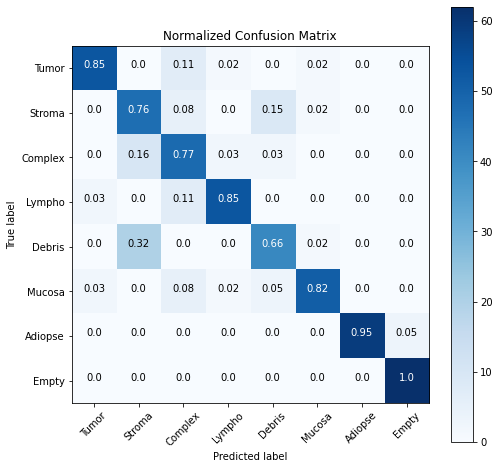

In [11]:
# normalized confusion matrix

y_test_nonbin = np.argmax(y_test, axis=1)

base_cm = tensorflow.math.confusion_matrix(y_test_nonbin, y_pred, num_classes=8).numpy()

figure = plt.figure(figsize=(8, 8))
plt.imshow(base_cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Normalized Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Normalize the confusion matrix.
norm_cm = np.around(base_cm.astype('float') / base_cm.sum(axis=1)[:, np.newaxis], decimals=2)

# Use white text if squares are dark; otherwise black.
threshold = norm_cm.max() / 2.

for i, j in itertools.product(range(norm_cm.shape[0]), range(norm_cm.shape[1])):
    color = "white" if norm_cm[i, j] > threshold else "black"
    plt.text(j, i, norm_cm[i, j], horizontalalignment="center", color=color)

plt.ylabel('True label')
plt.xlabel('Predicted label');
plt.savefig('hmt_cm.png')

**Precision/Recall/F1**

In [12]:
# Precision/Recall/F-1
precision = []
recall = []
f_1 = []
for i in range(8):
    precision.append(float(norm_cm[i, i])/float(sum(norm_cm[i, :])))
    recall.append(float(norm_cm[i, i])/float(sum(norm_cm[:, i])))
    f_1.append(2*precision[i]*recall[i]/(precision[i] + recall[i]))
    print(f'Class: {class_names[i]}')
    print(f'Precision: {precision[i]}')
    print(f'Recall: {recall[i]}')
    print(f'F1: {f_1[i]}')
    print()
    
print(f'Macro Precision: {sum(precision)/len(precision)}')
print(f'Macro Recall: {sum(recall)/len(recall)}')
print(f'Macro F1: {sum(f_1)/len(f_1)}')

Class: Tumor
Precision: 0.85
Recall: 0.934065934065934
F1: 0.8900523560209423

Class: Stroma
Precision: 0.7524752475247525
Recall: 0.6129032258064516
F1: 0.6755555555555555

Class: Complex
Precision: 0.7777777777777777
Recall: 0.6695652173913043
F1: 0.719626168224299

Class: Lympho
Precision: 0.8585858585858586
Recall: 0.9239130434782608
F1: 0.8900523560209423

Class: Debris
Precision: 0.66
Recall: 0.7415730337078651
F1: 0.6984126984126984

Class: Mucosa
Precision: 0.82
Recall: 0.9318181818181819
F1: 0.8723404255319148

Class: Adiopse
Precision: 0.95
Recall: 1.0
F1: 0.9743589743589743

Class: Empty
Precision: 1.0
Recall: 0.9523809523809523
F1: 0.975609756097561

Macro Precision: 0.8336048604860486
Macro Recall: 0.8457774485811188
Macro F1: 0.837001036277861


# Explanation

Load the explaier library

In [13]:
from xai_utils import *

In [14]:
# Correct: tumor 8, stroma 8, complex 8, lympho 4, debris 8, mucosa 4. adiopse 8, empty 8 - idx 0-8, 1-8, 2-8, 3-4, 4-8, 5-4, 6-8, 7-8
# Wrong: tumor 4, stroma 4, lympho 8, mucosa 8, debris 12 - idx -4, 1-4, 3-8, 5-8, 6-2

test_list = {0: {0: 8, 1: 8, 2: 8, 3: 5, 4: 8, 5: 4, 6: 8, 7: 8}, 1: {0: 4, 1: 4, 3: 8, 5: 8, 6: 2}}

pred_class_idx = []

test_generator.reset()
for loop_idx in range(2):
    # can't run the whole test image batch due to memory limitations, so multiple model calls were used. The entire class list is cycled through twice
    # loop_idx 0 - correct examples. loop_idx 1 - incorrect examples
    
    for class_idx in range(num_classes):
        image_batch,label_batch=test_generator.next()

        if class_idx in test_list[loop_idx]:
            
            prediction=model(image_batch)
            index = test_list[loop_idx][class_idx]
            pred_class_idx.append(np.argmax(prediction[test_list[loop_idx][class_idx]]))

            print(f'True label: {class_names[np.argmax(label_batch[index])]}')
            print('Predicted_label: '+class_names[np.argmax(prediction[test_list[loop_idx][class_idx]])])
            print('Confidence score for the correct label: '+str(prediction[index][np.argmax(label_batch[index])].numpy()))
            print()

True label: Tumor
Predicted_label: Tumor
Confidence score for the correct label: 0.96617067

True label: Stroma
Predicted_label: Stroma
Confidence score for the correct label: 0.73280275

True label: Complex
Predicted_label: Complex
Confidence score for the correct label: 0.6533546

True label: Lympho
Predicted_label: Lympho
Confidence score for the correct label: 0.9981329

True label: Debris
Predicted_label: Debris
Confidence score for the correct label: 0.89696014

True label: Mucosa
Predicted_label: Mucosa
Confidence score for the correct label: 0.7047237

True label: Adiopse
Predicted_label: Adiopse
Confidence score for the correct label: 0.9645454

True label: Empty
Predicted_label: Empty
Confidence score for the correct label: 0.8980478

True label: Tumor
Predicted_label: Complex
Confidence score for the correct label: 0.018222176

True label: Stroma
Predicted_label: Complex
Confidence score for the correct label: 0.4309024

True label: Lympho
Predicted_label: Complex
Confidence

Generate explanation map

## SISE (Semantic Input Sampling for Explanation)

Set the layer(s)

In [15]:
layers=[['conv2d_3']]

In [18]:
%%time

test_generator.reset()

expl_map_sise_list = []

list_idx = 0
for loop_idx in range(2):
    # loop_idx 0 - correct examples. loop_idx 1 - incorrect examples
    
    for class_idx in range(num_classes):
        image_batch,label_batch=test_generator.next()

        if class_idx in test_list[loop_idx]:
            
            index = test_list[loop_idx][class_idx]
            
            explanation_map_SISE = SISE(np.expand_dims(image_batch[index], axis=0), model, layers=layers, class_index=pred_class_idx[list_idx], grad_thr=0.)
            explanation_map_SISE -= explanation_map_SISE.min()
            explanation_map_SISE /= explanation_map_SISE.max()+10e-30
            
            expl_map_sise_list.append(explanation_map_SISE)
            
            list_idx += 1

CPU times: total: 2.34 s
Wall time: 2.32 s


## SmoothGrad

In [19]:
%%time

gradient_saliency = saliency.GradientSaliency()

def call_model_function(images, call_model_args=None, expected_keys=None):
    target_class_idx =  call_model_args['class_idx']
    images = tf.convert_to_tensor(images)
    
    with tf.GradientTape() as g:
        
        g.watch(images)

        output_layer = model(images)
        output_layer = output_layer[:,target_class_idx]
        gradients = np.array(g.gradient(output_layer, images))
    return {saliency.base.INPUT_OUTPUT_GRADIENTS: gradients}
        

expl_map_smoothgrad_list = []
test_generator.reset()
list_idx = 0
for loop_idx in range(2):
    # loop_idx 0 - correct examples. loop_idx 1 - incorrect examples
    
    for class_idx in range(num_classes):
        image_batch,label_batch=test_generator.next()

        if class_idx in test_list[loop_idx]:
            
            index = test_list[loop_idx][class_idx]
        
            smoothgrad_mask_3d = gradient_saliency.GetSmoothedMask(image_batch[index], call_model_function, {'class_idx': pred_class_idx[list_idx]}) 
            smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_mask_3d)
            
            # invert the output to match the size output (in the greyscale, higher intensity = more relevant
            smoothgrad_mask_grayscale = np.ones(smoothgrad_mask_grayscale.shape) - smoothgrad_mask_grayscale
            
            # equalise the output mask in the same fashion as the sise map
            smoothgrad_mask_grayscale -= smoothgrad_mask_grayscale.min()
            smoothgrad_mask_grayscale /= smoothgrad_mask_grayscale.max()+10e-30
            
            
            
            expl_map_smoothgrad_list.append(smoothgrad_mask_grayscale)
            
            list_idx += 1

CPU times: total: 5.52 s
Wall time: 5.55 s


## Plot the results

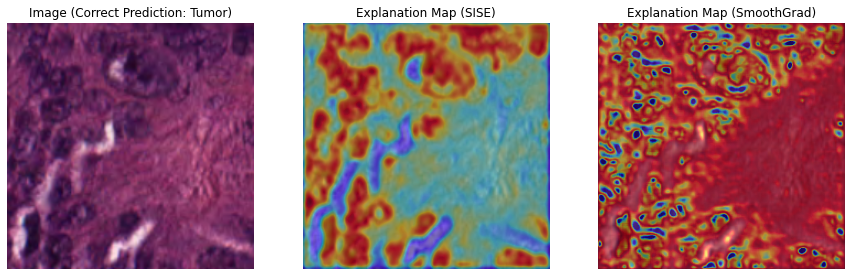

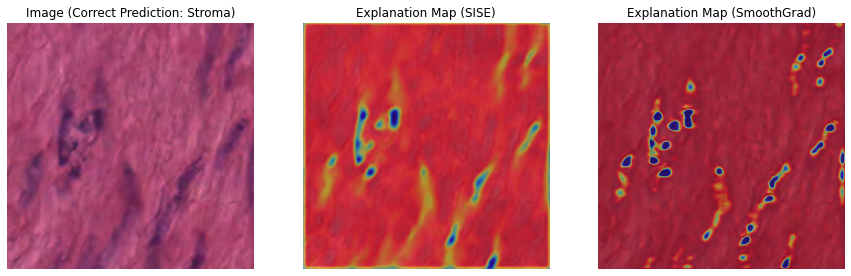

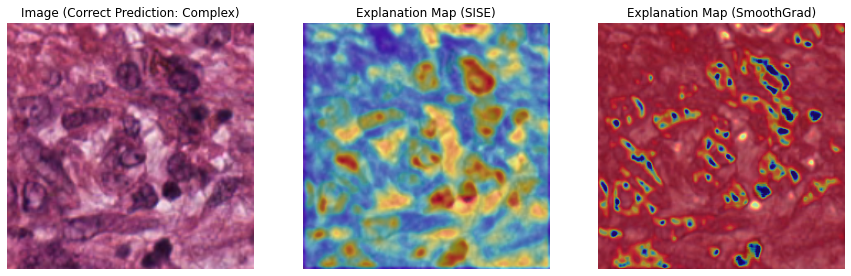

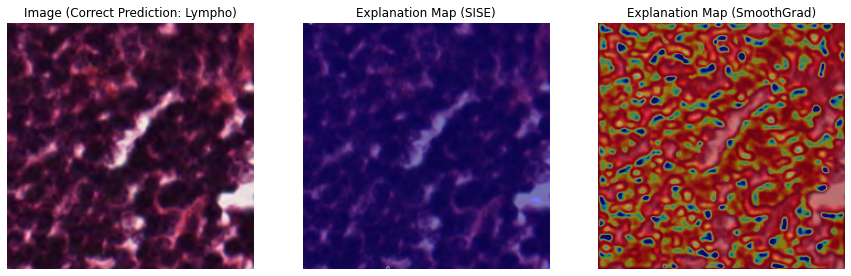

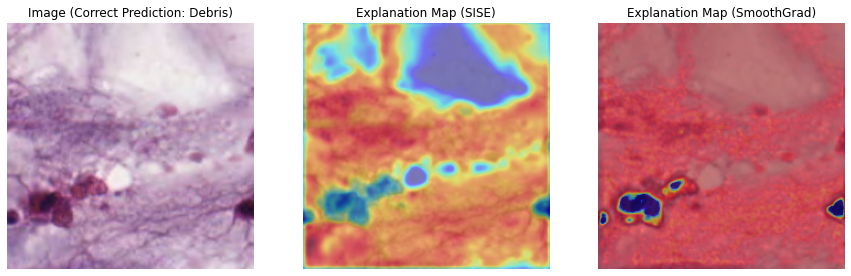

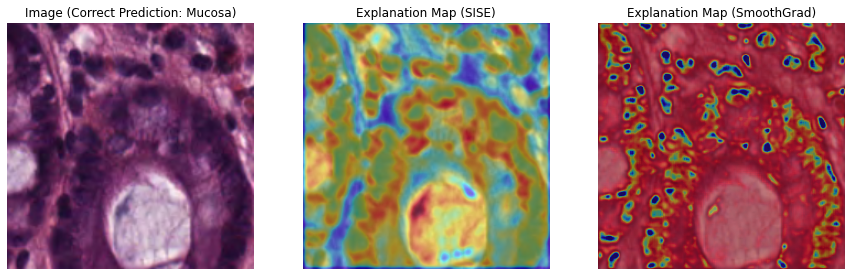

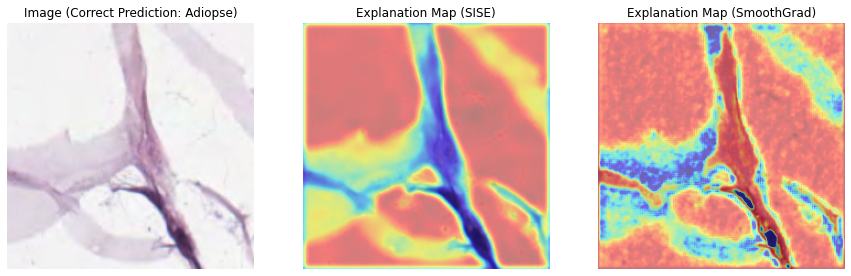

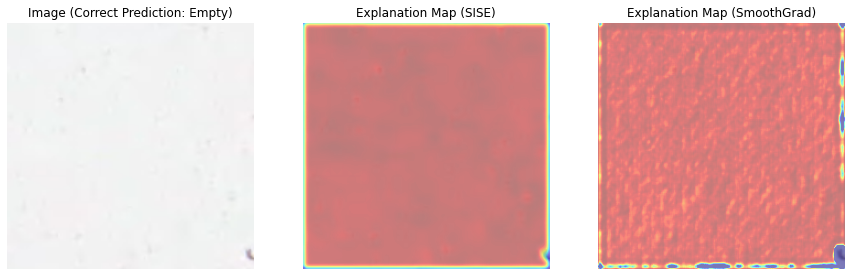

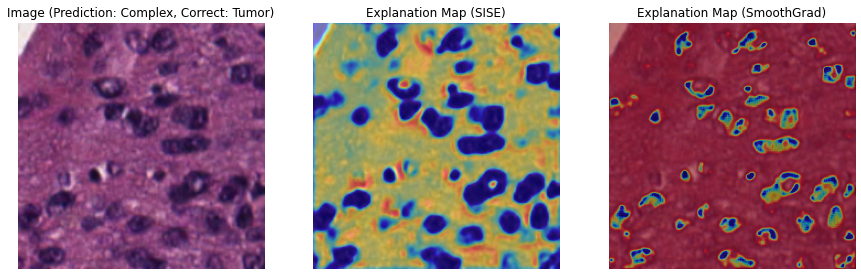

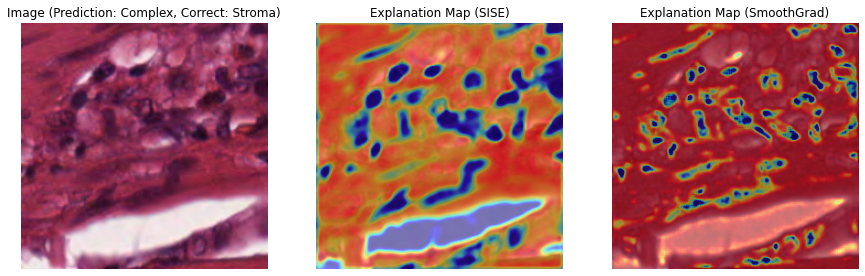

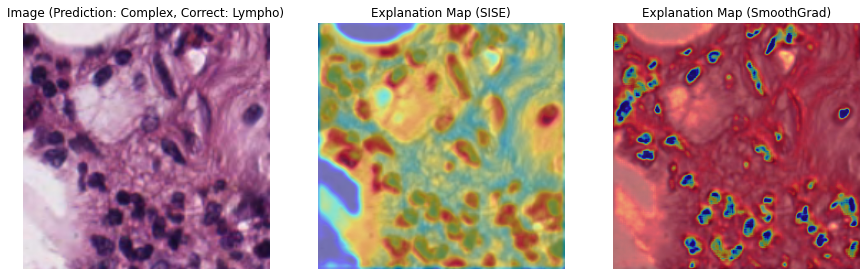

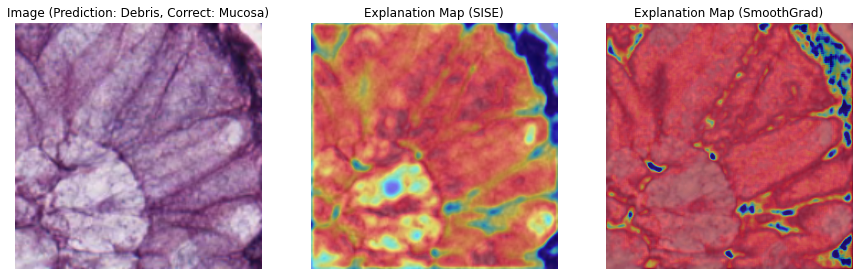

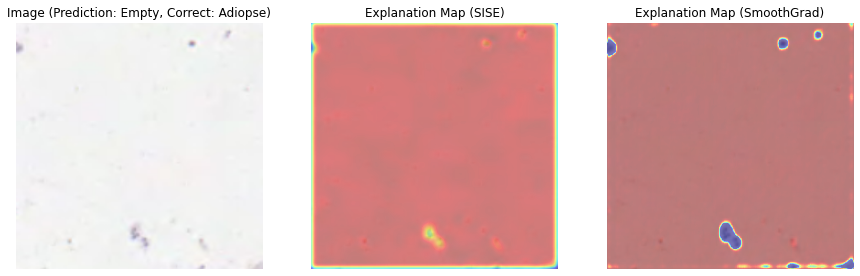

In [20]:
#@title Plot the results
test_generator.reset()
list_idx = 0
for loop_idx in range(2):
    # loop_idx 0 - correct examples. loop_idx 1 - incorrect examples
    for class_idx in range(num_classes):
        image_batch,label_batch=test_generator.next()
        if class_idx in test_list[loop_idx]:
            index = test_list[loop_idx][class_idx]
            plt.figure(figsize=(15,5))

            pred_class_idx[list_idx]
            
            plt.subplot(131)
            plt.imshow(image_batch[index])
            plt.axis('off')
            plt.title(f'Image ({"Correct " if not loop_idx else ""}Prediction: {class_names[pred_class_idx[list_idx]]}' + 
                      (')' if not loop_idx else f', Correct: {class_names[class_idx]})'))

            plt.subplot(132)
            plt.imshow(image_batch[index])
            plt.imshow(expl_map_sise_list[list_idx], cmap='jet', alpha=0.5)
            plt.axis('off')
            plt.title('Explanation Map (SISE)')

            plt.subplot(133)
            plt.imshow(image_batch[index])
            plt.imshow(expl_map_smoothgrad_list[list_idx], cmap='jet', alpha=0.5)
            plt.axis('off')
            plt.title('Explanation Map (SmoothGrad)');
            
            plt.savefig(f'hmt_{"corr" if not loop_idx else "incorr"}_{class_names[class_idx]}.png')
            
            list_idx += 1
            
            

## Quantitative evaluation of the explanation algorithm

In [21]:
def calculate_drop_increase(images, model, exmap, class_index, frac=0.15):
    '''
    inputs:
        images: a 4-D image of size (1 x H x W x 3)
          containing an image in RGB format and of size (H x W)
        model: The base model
        exmap: a given explanation map whose completeness is to be evaluated.
        class_index: The class to whom the explanation map is related to.
        frac: The fraction of top pixels selected.
    returns:v
        a tuple with 4 calculates values:
        (drop, increase, original_pred, eplanation_pred)
        drop (float): drop rate (between 0 and 1)
        increase (boolean): "1" if increase happened
        original_pred: confidence score for original image
        explanation_pred:  confidence score for the selected top pixels of the image.
    '''
    predictions = model.predict(images)
    # Pre-processing image 
    img=images[0,:,:,:]
    img=img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Getting the prediction for image
    Y=predictions[0][class_index]
    
    grad_array=np.reshape(exmap, (-1,))
    array_size=int(grad_array.shape[0]*frac)
    thr=np.flip(sorted(grad_array))[array_size]
    exmap1_msk=(exmap>thr)
    exmap1_thr=np.zeros(shape=(1,224,224,3))
    exmap1_thr[0,:,:,0]=img[0,:,:,0]*exmap1_msk
    exmap1_thr[0,:,:,1]=img[0,:,:,1]*exmap1_msk
    exmap1_thr[0,:,:,2]=img[0,:,:,2]*exmap1_msk
    ex_predictions = model.predict(exmap1_thr)[0]
    O1=ex_predictions[class_index]
    etta=(Y-O1)/(Y+1e-100)
    return (etta*(etta>0), 1*(etta<0), Y, O1)

In [22]:
val_generator.reset()
sise_drop_rate = 0.
sise_increase_rate = 0.
for _ in range(15):
    image_batch,label_batch=val_generator.next()
    for index in range(32):
        prediction=model(image_batch)
        explanation_map_SISE = SISE(np.expand_dims(image_batch[index], axis=0), model, layers=layers, class_index=np.argmax(prediction[index]), grad_thr=0.)
        drop_increase_rate = calculate_drop_increase(np.expand_dims(image_batch[index], axis=0), model, explanation_map_SISE, class_index=np.argmax(prediction[index]), frac=0.9)
        sise_drop_rate += drop_increase_rate[0]
        sise_increase_rate += drop_increase_rate[1]
sise_drop_rate /= (15*32)
sise_increase_rate /= (15*32)

print(f'SISE Drop Rate: {sise_drop_rate}')
print(f'SISE Increase Rate: {sise_increase_rate}')

SISE Drop Rate: 0.5977349715010634
SISE Increase Rate: 0.17916666666666667


In [23]:
val_generator.reset()
smoothgrad_drop_rate = 0.
smoothgrad_increase_rate = 0.
for _ in range(15):
    image_batch,label_batch=val_generator.next()
    for index in range(32):
        prediction=model(image_batch)
        
        smoothgrad_mask_3d = gradient_saliency.GetSmoothedMask(image_batch[index], call_model_function, {'class_idx':np.argmax(prediction[index])}) 
        smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_mask_3d)

        # invert the output to match the size output (in the greyscale, higher intensity = more relevant
        smoothgrad_mask_grayscale = np.ones(smoothgrad_mask_grayscale.shape) - smoothgrad_mask_grayscale
        drop_increase_rate = calculate_drop_increase(np.expand_dims(image_batch[index], axis=0), model, smoothgrad_mask_grayscale, class_index=np.argmax(prediction[index]), frac=0.9)
        smoothgrad_drop_rate += drop_increase_rate[0]
        smoothgrad_increase_rate += drop_increase_rate[1]
smoothgrad_drop_rate /= (15*32)
smoothgrad_increase_rate /= (15*32)
                                                                                                         
print(f'SmoothGrad Drop Rate: {smoothgrad_drop_rate}')
print(f'SmoothGrad Increase Rate: {smoothgrad_increase_rate}')

SmoothGrad Drop Rate: 0.663622951780472
SmoothGrad Increase Rate: 0.22083333333333333
